# Data Preparation

In this notebook the goal is to prepare the dataset (csv or excel) to train the Random Forest Classifier for land cover classification. The dataset would be composed of : 

- annual fractional cover (bs, pv, npv)
- RGB
- NDVI, NDWI, NDWI, EVI
- DEM (elevation)
- RADAR data (sentinel 1)
- monthly NDVI
- seasonal fractional cover

In [1]:
import pandas as pd
import numpy as np 
import xarray as xr
import random
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import rasterio
from matplotlib.patches import Patch
import seaborn as sns

import os
import sys

from pystac_client import Client
import depal_ck as dep
from odc.stac import load
from shapely import geometry
import rioxarray
from dea_tools.dask import create_local_dask_cluster

client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/philippinel@spc.int/proxy/8787/status,
Dashboard: /user/philippinel@spc.int/proxy/8787/status,Workers: 1
Total threads: 8,Total memory: 57.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45463,Workers: 0
Dashboard: /user/philippinel@spc.int/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:34201,Total threads: 8
Dashboard: /user/philippinel@spc.int/proxy/40885/status,Memory: 57.21 GiB
Nanny: tcp://127.0.0.1:37919,


In [2]:
catalog = "https://stac.staging.digitalearthpacific.io"
client = Client.open(catalog)
collections = client.get_collections()

In [24]:
# AOI FIJI CENTRAL + WESTERN
divisions = ['Central', 'Western']

# Fetch boundaries
gdfs = [dep.get_country_admin_boundary('Fiji', 'Division', division) for division in divisions]

# Union into one AOI
aoi = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)
aoi_union = aoi.unary_union

# Bounding box of the union
bbox = aoi_union.bounds 
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

In [3]:
# AOI COOK ISLANDS
aoi = dep.get_country_admin_boundary('Cook Islands', 'Island Council', "Rarotonga")
bbox = dep.get_bbox(aoi)
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')

In [54]:
# AOI MARSHALL ISLANDS
aoi = dep.get_country_admin_boundary('Marshall Islands', 'Atoll', "Majuro")
bbox = dep.get_bbox(aoi)
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')

In [ ]:
# AOI PALAU 

# List of Palau states

states = [
    "Aimeliik",
    "Airai",
    "Koror",
    "Melekeok",
    "Ngaraard",
    "Ngardmau",
    "Ngatpang",
    "Ngchesar",
    "Ngeremlengui",
    "Ngiwal", 
    "Ngarchelong"
]


gdfs = [dep.get_country_admin_boundary('Palau', 'State', state) for state in states]

aoi = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)
aoi_union = aoi.unary_union

# Bounding box of the union
bbox = aoi_union.bounds 
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

## ANNUAL FRACTIONAL COVER

In [4]:
items = client.search(collections=["dep_ls_fc_summary_annual"], bbox=bbox).item_collection()
print(f"Found {len(items)} items")

Found 1 items


In [10]:
items = client.search(
    collections=["dep_ls_fc_summary_annual"],
    bbox=bbox,
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks)

#area = gpd.GeoDataFrame({"geometry": [bbox_geometry]}, crs="EPSG:32660")
#data = dep.do_coastal_clip(area, data, buffer=0.001)
fc = data[["bs_pc_50", "pv_pc_50", "npv_pc_50"]]

if not fc.rio.crs:
    print('change')
    fc = fc.rio.write_crs("EPSG:32604")

# Reproject to EPSG:4326
fc= fc.rio.reproject("EPSG:4326") 

"""
if fc.sizes["time"] == 1:
    fc = fc.isel(time=0)
"""
print(fc)

<xarray.Dataset> Size: 123MB
Dimensions:      (x: 3302, y: 3094, time: 1)
Coordinates:
  * x            (x) float64 26kB -160.2 -160.2 -160.2 ... -159.3 -159.3 -159.3
  * y            (y) float64 25kB -20.93 -20.93 -20.93 ... -21.73 -21.74 -21.74
  * time         (time) datetime64[ns] 8B 2024-01-01
    spatial_ref  int64 8B 0
Data variables:
    bs_pc_50     (time, y, x) float32 41MB nan nan nan nan ... nan nan nan nan
    pv_pc_50     (time, y, x) float32 41MB nan nan nan nan ... nan nan nan nan
    npv_pc_50    (time, y, x) float32 41MB nan nan nan nan ... nan nan nan nan


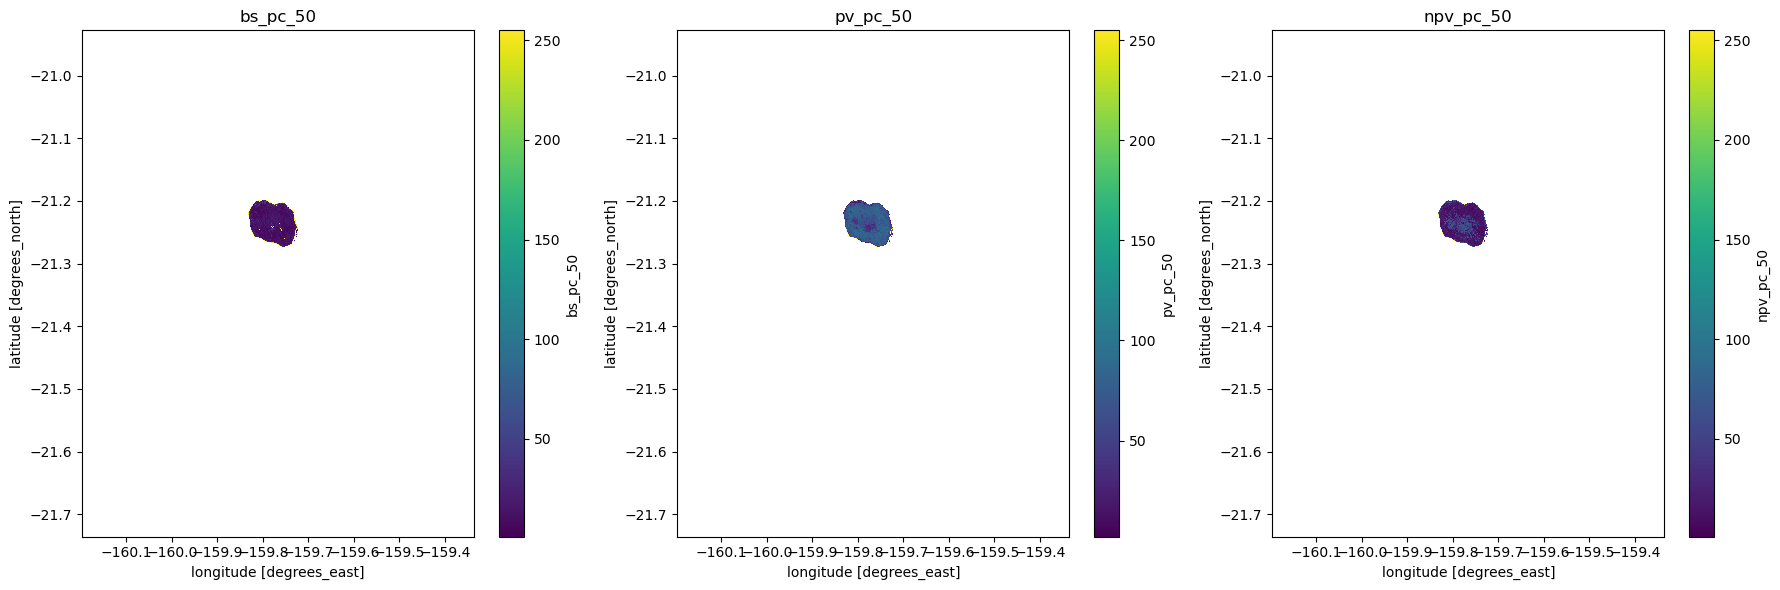

In [8]:
bands = ["bs_pc_50", "pv_pc_50", "npv_pc_50"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, band in enumerate(bands):
    fc[band].isel(time=0).plot(ax=axes[i], cmap="viridis")
    axes[i].set_title(band)

plt.tight_layout()
plt.show()

In [11]:
bs_cook = fc['bs_pc_50']
bs_cook.rio.write_crs("EPSG:4326", inplace=True) 
bs_cook.rio.to_raster("./data/preparation/bs_annual_cook.tif")

## RGB + INDEXES (NDVI, NDWI, NDBI, ...)

In [12]:
items = client.search(collections=["dep_s2_geomad"], bbox=bbox).item_collection()
print(f"Found {len(items)} items")

Found 3 items


In [64]:
items = client.search(
    collections=["dep_s2_geomad"],
    bbox=bbox,
    datetime="2024-01-01/2024-12-31",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks)
spectral = data[["red", "blue", "green", "nir08", "swir16"]]
spectral = dep.do_coastal_clip(aoi, spectral , buffer=0.001)
spectral = spectral.where(spectral != 0, np.nan)


print(spectral)

<xarray.Dataset> Size: 43MB
Dimensions:      (time: 1, y: 889, x: 1209)
Coordinates:
  * y            (y) float64 7kB -2.4e+06 -2.4e+06 ... -2.409e+06 -2.409e+06
  * x            (x) float64 10kB 5.585e+06 5.585e+06 ... 5.597e+06 5.597e+06
  * time         (time) datetime64[ns] 8B 2024-01-01
    spatial_ref  int64 8B 0
Data variables:
    red          (time, y, x) float64 9MB dask.array<chunksize=(1, 887, 25), meta=np.ndarray>
    blue         (time, y, x) float64 9MB dask.array<chunksize=(1, 887, 25), meta=np.ndarray>
    green        (time, y, x) float64 9MB dask.array<chunksize=(1, 887, 25), meta=np.ndarray>
    nir08        (time, y, x) float64 9MB dask.array<chunksize=(1, 887, 25), meta=np.ndarray>
    swir16       (time, y, x) float64 9MB dask.array<chunksize=(1, 887, 25), meta=np.ndarray>


In [65]:


def add_indices(data: xr.Dataset) -> xr.Dataset:
    """
    Add common spectral indices to a Sentinel-2 xarray Dataset.
    Works with bands: red, green, blue, nir08, swir16.
    """
    # Ensure float32 for calculations
    for band in ["red", "green", "blue", "nir08", "swir16"]:
        data[band] = data[band].astype("float64")

    # NDVI = (NIR - Red) / (NIR + Red)
    data["ndvi"] = (data["nir08"] - data["red"]) / (data["nir08"] + data["red"])

    # MNDWI = (Green - SWIR) / (Green + SWIR)
    data["mndwi"] = (data["green"] - data["swir16"]) / (data["green"] + data["swir16"])

    # EVI = 2.5 * (NIR - Red) / (NIR + 6*Red - 7.5*Blue + 1)
    #data["evi"] = (2.5 * (data["nir08"] - data["red"])) / (data["nir08"] + 6 * data["red"] - 7.5 * data["blue"] + 1)

    # SAVI = (1 + L) * (NIR - Red) / (NIR + Red + L), L=0.5
    L = 0.5
    #data["savi"] = (1 + L) * (data["nir08"] - data["red"]) / (data["nir08"] + data["red"] + L)

    # BSI (Bare Soil Index) = (SWIR + Red - NIR - Blue) / (SWIR + Red + NIR + Blue)
    #data["bsi"] = (data["swir16"] + data["red"] - data["nir08"] - data["blue"]) / (
    #    data["swir16"] + data["red"] + data["nir08"] + data["blue"]
    #)

    # NDMI (Normalized Difference Moisture Index) = (NIR - SWIR) / (NIR + SWIR)
    #data["ndmi"] = (data["nir08"] - data["swir16"]) / (data["nir08"] + data["swir16"])

    # NDBI (Normalized Difference Built-up Index) = (SWIR - NIR) / (SWIR + NIR)
    data["ndbi"] = (data["swir16"] - data["nir08"]) / (data["swir16"] + data["nir08"])

    return data


In [66]:
spectral = add_indices(spectral)

if not spectral.rio.crs:
    spectral = spectral.rio.write_crs("EPSG:3832")  # or correct CRS


spectral = spectral.rio.reproject("EPSG:4326")

print(spectral)

<xarray.Dataset> Size: 67MB
Dimensions:      (x: 1236, y: 852, time: 1)
Coordinates:
  * x            (x) float64 10kB -159.8 -159.8 -159.8 ... -159.7 -159.7 -159.7
  * y            (y) float64 7kB -21.2 -21.2 -21.2 ... -21.27 -21.27 -21.27
  * time         (time) datetime64[ns] 8B 2024-01-01
    spatial_ref  int64 8B 0
Data variables:
    red          (time, y, x) float64 8MB nan nan nan nan ... nan nan nan nan
    blue         (time, y, x) float64 8MB nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float64 8MB nan nan nan nan ... nan nan nan nan
    nir08        (time, y, x) float64 8MB nan nan nan nan ... nan nan nan nan
    swir16       (time, y, x) float64 8MB nan nan nan nan ... nan nan nan nan
    ndvi         (time, y, x) float64 8MB nan nan nan nan ... nan nan nan nan
    mndwi        (time, y, x) float64 8MB nan nan nan nan ... nan nan nan nan
    ndbi         (time, y, x) float64 8MB nan nan nan nan ... nan nan nan nan


In [36]:
red = spectral['red']
red.rio.write_crs("EPSG:4326", inplace=True) 
red.rio.to_raster("./data/preparation/red_cook.tif")

ndvi = spectral['ndvi']
ndvi.rio.write_crs("EPSG:4326", inplace=True) 
ndvi.rio.to_raster("./data/preparation/ndvi_cook.tif")

## SEASONNAL FRACTIONAL COVER 

In [48]:
####################################################################
# JANUARY - APRIL FC 
####################################################################

# WOFL Landsat-8 Image --> USED AS THE MASK TO REMOVE CLOUD
items = client.search(collections=["dep_ls_wofl"], bbox=bbox, datetime="2024-01-01/2024-04-30").item_collection()

items = client.search(
    collections=["dep_ls_wofl"],
    bbox=bbox,
    datetime="2024-01-01/2024-04-30",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data_temoin = load(items, chunks=chunks)
data_temoin = dep.do_coastal_clip(aoi, data_temoin , buffer=0.001)

# FC Landsat-8 Image 
items = client.search(
    collections=["dep_ls_fc"],
    bbox=bbox,
    datetime="2024-01-01/2024-04-30",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks)
data = dep.do_coastal_clip(aoi, data, buffer=0.001)

#######################################################################
# Extract just the dates (YYYY-MM-DD)
data_dates = pd.to_datetime(data.time.values).normalize()
temoin_dates = pd.to_datetime(data_temoin.time.values).normalize()

# Build index mapping by date 
data_idx = {d: i for i, d in enumerate(data_dates)}
temoin_idx = {d: j for j, d in enumerate(temoin_dates)}

# Find common dates
common_dates = sorted(set(data_idx.keys()) & set(temoin_idx.keys()))

# Initialize masked copy
data_masked = data.copy()

# Loop over matching dates
for date in common_dates:
    
    i = data_idx[date]
    j = temoin_idx[date]
    mask = data_temoin['water'].isel(time=j) == 1

    for band in ['bs', 'pv', 'npv']:
        
        band_slice = data[band].isel(time=i)
        mask_aligned = mask.broadcast_like(band_slice)
        masked_slice = band_slice.where(~mask_aligned, 255)
        data_masked[band][i] = masked_slice
        
#########################################################################
# Compute the seasonal median
clean = data_masked.where(data_masked != 255)
median_ds = clean.median(dim="time", skipna=True)

bs_median  = median_ds['bs']
pv_median  = median_ds['pv']
npv_median = median_ds['npv']

fc_jan_apr = xr.Dataset(
    {
        "bs_jan_apr": bs_median,
        "pv_jan_apr": pv_median,
        "npv_jan_apr": npv_median
    }
)

####################################################################
# Reproject to EPSG:4326
if not fc_jan_apr.rio.crs:
    fc_jan_apr = fc_jan_apr.rio.write_crs("EPSG:32604")
fc_jan_apr= fc_jan_apr.rio.reproject("EPSG:4326")

# Add time dimension
time_coord = pd.to_datetime("2024-01-01")
fc_jan_apr = fc_jan_apr.expand_dims(time=[time_coord])
fc_jan_apr = fc_jan_apr.transpose('time', 'y', 'x')


print(fc_jan_apr)

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 1, x: 387, y: 267)
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-01-01
  * x            (x) float64 3kB -159.8 -159.8 -159.8 ... -159.7 -159.7 -159.7
  * y            (y) float64 2kB -21.2 -21.2 -21.2 ... -21.27 -21.27 -21.27
    spatial_ref  int64 8B 0
Data variables:
    bs_jan_apr   (time, y, x) float32 413kB nan nan nan nan ... nan nan nan nan
    pv_jan_apr   (time, y, x) float32 413kB nan nan nan nan ... nan nan nan nan
    npv_jan_apr  (time, y, x) float32 413kB nan nan nan nan ... nan nan nan nan


In [50]:
####################################################################
# MAY - AUGUST FC 
####################################################################

# WOFL Landsat-8 Image --> USED AS THE MASK TO REMOVE CLOUD
items = client.search(collections=["dep_ls_wofl"], bbox=bbox, datetime="2024-05-01/2024-08-31").item_collection()

items = client.search(
    collections=["dep_ls_wofl"],
    bbox=bbox,
    datetime="2024-05-01/2024-08-31",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data_temoin = load(items, chunks=chunks)
data_temoin = dep.do_coastal_clip(aoi, data_temoin , buffer=0.001)

# FC Landsat-8 Image 
items = client.search(
    collections=["dep_ls_fc"],
    bbox=bbox,
    datetime="2024-05-01/2024-08-31",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks)
data = dep.do_coastal_clip(aoi, data, buffer=0.001)

#######################################################################
# Extract just the dates (YYYY-MM-DD)
data_dates = pd.to_datetime(data.time.values).normalize()
temoin_dates = pd.to_datetime(data_temoin.time.values).normalize()

# Build index mapping by date 
data_idx = {d: i for i, d in enumerate(data_dates)}
temoin_idx = {d: j for j, d in enumerate(temoin_dates)}

# Find common dates
common_dates = sorted(set(data_idx.keys()) & set(temoin_idx.keys()))

# Initialize masked copy
data_masked = data.copy()

# Loop over matching dates
for date in common_dates:
    
    i = data_idx[date]
    j = temoin_idx[date]
    mask = data_temoin['water'].isel(time=j) == 1

    for band in ['bs', 'pv', 'npv']:
        
        band_slice = data[band].isel(time=i)
        mask_aligned = mask.broadcast_like(band_slice)
        masked_slice = band_slice.where(~mask_aligned, 255)
        data_masked[band][i] = masked_slice
        
#########################################################################
# compute the seasonal median
clean = data_masked.where(data_masked != 255)
median_ds = clean.median(dim="time", skipna=True)

bs_median  = median_ds['bs']
pv_median  = median_ds['pv']
npv_median = median_ds['npv']

fc_may_aug = xr.Dataset(
    {
        "bs_may_aug": bs_median,
        "pv_may_aug": pv_median,
        "npv_may_aug": npv_median
    }
)

####################################################################
# Reproject to EPSG:4326
if not fc_may_aug.rio.crs:
    fc_may_aug = fc_may_aug.rio.write_crs("EPSG:32604")
fc_may_aug= fc_may_aug.rio.reproject("EPSG:4326")

# Add time dimension
time_coord = pd.to_datetime("2024-01-01")
fc_may_aug = fc_may_aug.expand_dims(time=[time_coord])
fc_may_aug = fc_may_aug.transpose('time', 'y', 'x')


print(fc_may_aug)

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 1, x: 387, y: 267)
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-01-01
  * x            (x) float64 3kB -159.8 -159.8 -159.8 ... -159.7 -159.7 -159.7
  * y            (y) float64 2kB -21.2 -21.2 -21.2 ... -21.27 -21.27 -21.27
    spatial_ref  int64 8B 0
Data variables:
    bs_may_aug   (time, y, x) float32 413kB nan nan nan nan ... nan nan nan nan
    pv_may_aug   (time, y, x) float32 413kB nan nan nan nan ... nan nan nan nan
    npv_may_aug  (time, y, x) float32 413kB nan nan nan nan ... nan nan nan nan


In [51]:
####################################################################
# SEPTEMBER - DECEMBER FC 
####################################################################

# WOFL Landsat-8 Image --> USED AS THE MASK TO REMOVE CLOUD
items = client.search(collections=["dep_ls_wofl"], bbox=bbox, datetime="2024-09-01/2024-12-31").item_collection()

items = client.search(
    collections=["dep_ls_wofl"],
    bbox=bbox,
    datetime="2024-09-01/2024-12-31",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data_temoin = load(items, chunks=chunks)
data_temoin = dep.do_coastal_clip(aoi, data_temoin , buffer=0.001)

# FC Landsat-8 Image 
items = client.search(
    collections=["dep_ls_fc"],
    bbox=bbox,
    datetime="2024-09-01/2024-12-31",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks)
data = dep.do_coastal_clip(aoi, data, buffer=0.001)

#######################################################################
# Extract just the dates (YYYY-MM-DD)
data_dates = pd.to_datetime(data.time.values).normalize()
temoin_dates = pd.to_datetime(data_temoin.time.values).normalize()

# Build index mapping by date 
data_idx = {d: i for i, d in enumerate(data_dates)}
temoin_idx = {d: j for j, d in enumerate(temoin_dates)}

# Find common dates
common_dates = sorted(set(data_idx.keys()) & set(temoin_idx.keys()))

# Initialize masked copy
data_masked = data.copy()

# Loop over matching dates
for date in common_dates:
    
    i = data_idx[date]
    j = temoin_idx[date]
    mask = data_temoin['water'].isel(time=j) == 1

    for band in ['bs', 'pv', 'npv']:
        
        band_slice = data[band].isel(time=i)
        mask_aligned = mask.broadcast_like(band_slice)
        masked_slice = band_slice.where(~mask_aligned, 255)
        data_masked[band][i] = masked_slice
        
#########################################################################
# compute the seasonal median
clean = data_masked.where(data_masked != 255)
median_ds = clean.median(dim="time", skipna=True)

bs_median  = median_ds['bs']
pv_median  = median_ds['pv']
npv_median = median_ds['npv']

fc_sep_dec = xr.Dataset(
    {
        "bs_sep_dec": bs_median,
        "pv_sep_dec": pv_median,
        "npv_sep_dec": npv_median
    }
)

####################################################################
# Reproject to EPSG:4326
if not fc_sep_dec.rio.crs:
    fc_sep_dec = fc_sep_dec.rio.write_crs("EPSG:32604")
fc_sep_dec = fc_sep_dec.rio.reproject("EPSG:4326")

# Add time dimension
time_coord = pd.to_datetime("2024-01-01")
fc_sep_dec = fc_sep_dec.expand_dims(time=[time_coord])
fc_sep_dec = fc_sep_dec.transpose('time', 'y', 'x')

print(fc_sep_dec)

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 1, x: 387, y: 267)
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-01-01
  * x            (x) float64 3kB -159.8 -159.8 -159.8 ... -159.7 -159.7 -159.7
  * y            (y) float64 2kB -21.2 -21.2 -21.2 ... -21.27 -21.27 -21.27
    spatial_ref  int64 8B 0
Data variables:
    bs_sep_dec   (time, y, x) float32 413kB nan nan nan nan ... nan nan nan nan
    pv_sep_dec   (time, y, x) float32 413kB nan nan nan nan ... nan nan nan nan
    npv_sep_dec  (time, y, x) float32 413kB nan nan nan nan ... nan nan nan nan


## SENTINEL 1 (RADAR)

In [69]:
items = client.search(collections=["dep_s1_geomad"], bbox=bbox).item_collection()
print(f"Found {len(items)} items")

Found 4 items


In [70]:
items = client.search(
    collections=["dep_s1_geomad"],
    bbox=bbox,
).items()
chunks = dict(x=2048, y=2048)

# Load the data
radar = load(items, chunks=chunks)

radar = dep.do_coastal_clip(aoi, radar, buffer=0.001)

print(radar)

<xarray.Dataset> Size: 1GB
Dimensions:      (y: 7352, x: 4703, time: 1)
Coordinates:
  * y            (y) float64 59kB 8.607e+05 8.607e+05 ... 7.872e+05 7.872e+05
  * x            (x) float64 38kB -1.756e+06 -1.756e+06 ... -1.709e+06
  * time         (time) datetime64[ns] 8B 2024-01-01
    spatial_ref  int64 8B 0
Data variables:
    vh           (time, y, x) float32 138MB dask.array<chunksize=(1, 563, 1052), meta=np.ndarray>
    vv           (time, y, x) float32 138MB dask.array<chunksize=(1, 563, 1052), meta=np.ndarray>
    emad         (time, y, x) float32 138MB dask.array<chunksize=(1, 563, 1052), meta=np.ndarray>
    smad         (time, y, x) float32 138MB dask.array<chunksize=(1, 563, 1052), meta=np.ndarray>
    bcmad        (time, y, x) float32 138MB dask.array<chunksize=(1, 563, 1052), meta=np.ndarray>
    count        (time, y, x) uint16 69MB dask.array<chunksize=(1, 563, 1052), meta=np.ndarray>
    mean_vh      (time, y, x) float32 138MB dask.array<chunksize=(1, 563, 1052), me

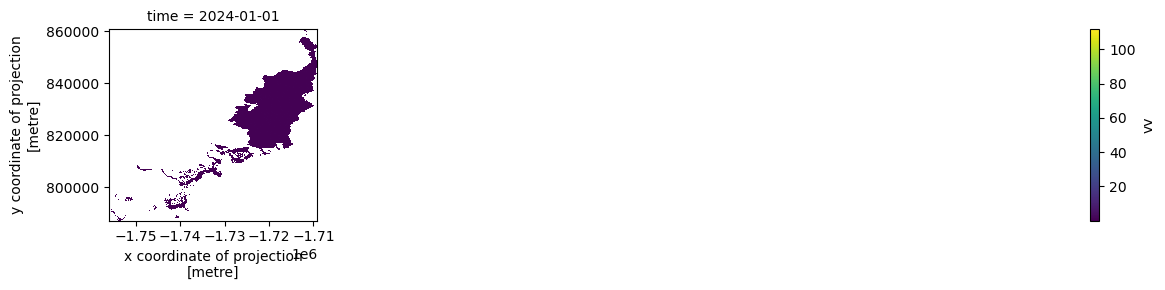

In [72]:
dep.visualise(radar['vv'])

In [ ]:
# IF 0 ITEMS FOUND ON DEP STAC API STAGING 
from dep_tools.searchers import PystacSearcher

def get_sentinel_searcher():
    today = date.today().isoformat()
    return PystacSearcher(
        catalog="https://earth-search.aws.element84.com/v1",
        collections=["sentinel-1-rtc"],  
        datetime="2024-01-01/2024-12-31",
    )


s2_searcher = get_sentinel_searcher()
items = s2_searcher.search(gdf)  
print(len(items), "items found")

## DEM 

In [52]:
# run_task.py
from dep_tools.searchers import PystacSearcher

def get_dem_searcher():
    """Return a PystacSearcher for DEM (Copernicus DEM)."""
    return PystacSearcher(
        catalog="https://earth-search.aws.element84.com/v1",
        collections=["cop-dem-glo-30"],
    )

In [53]:

dem_searcher = get_dem_searcher()

# Run searches
dem_items = dem_searcher.search(gdf)

print("DEM items:", len(dem_items))

DEM items: 1


In [115]:
from dep_tools.loaders import OdcLoader
loader = OdcLoader(
    crs=4326,
    chunks=dict( x=2048, y=2048),
)


dem_data = loader.load(dem_items, gdf)
dem_data = dep.do_coastal_clip(aoi, dem_data, buffer=0.001)

dem_data = dem_data.rename({
    "latitude": "y",
    "longitude": "x"
})
dem_data = dem_data.assign_coords(time=[np.datetime64("2024-01-01")])
dem_data = dem_data.rename({"data": "dem"})
print(dem_data)

<xarray.Dataset> Size: 421kB
Dimensions:      (y: 269, x: 386, time: 1)
Coordinates:
  * y            (y) float64 2kB -21.2 -21.2 -21.2 ... -21.27 -21.27 -21.27
  * x            (x) float64 3kB -159.8 -159.8 -159.8 ... -159.7 -159.7 -159.7
    spatial_ref  int64 8B 0
  * time         (time) datetime64[s] 8B 2024-01-01
Data variables:
    dem          (time, y, x) float32 415kB dask.array<chunksize=(1, 269, 386), meta=np.ndarray>


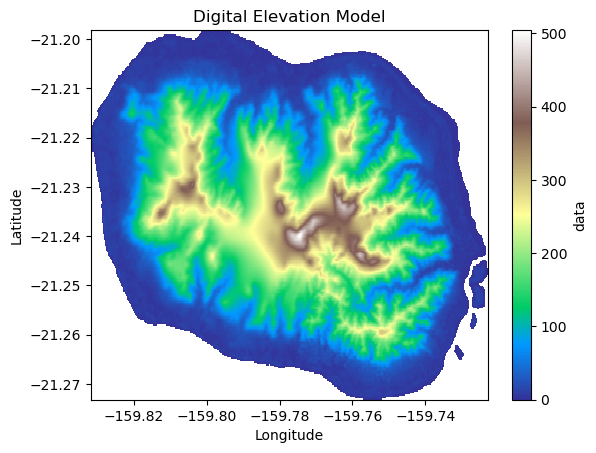

In [87]:
# Plot the first variable
var_name = list(dem_data.data_vars)[0]  
dem_data[var_name].plot(cmap="terrain")  
plt.title("Digital Elevation Model")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## GLCM TEXTURE 

In [127]:
import dask.array as da
from skimage.feature import graycomatrix, graycoprops


def glcm_features(patch, distances=[5], angles=[0], levels=256):
    # Skip NaNs
    if np.isnan(patch).any() or patch.max() == patch.min():
        return {k: np.nan for k in [
            "contrast","dissimilarity","homogeneity","energy","correlation","entropy"
        ]}

    # Scale NDVI-like values [-1,1] → [0,255]
    patch_scaled = np.clip(((patch + 1) * 127.5).astype(np.uint8), 0, 255)

    glcm = graycomatrix(
        patch_scaled, distances=distances, angles=angles,
        levels=levels, symmetric=True, normed=True
    )

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    p = glcm / glcm.sum()
    p = p[p > 0]
    entropy = -np.sum(p * np.log2(p))

    return {
        "contrast": contrast,
        "dissimilarity": dissimilarity,
        "homogeneity": homogeneity,
        "energy": energy,
        "correlation": correlation,
        "entropy": entropy
    }

# Compute GLCM patch by patch (for computationnal efficiency)
def compute_glcm_patchwise(band_da, window_size=64):
    
    ysize, xsize = band_da.shape[-2:]
    pad_y = (window_size - ysize % window_size) % window_size
    pad_x = (window_size - xsize % window_size) % window_size

    padded = da.pad(band_da.data[0], ((0, pad_y), (0, pad_x)), mode="reflect")

    # Split into patches
    reshaped = padded.reshape(
        padded.shape[0] // window_size, window_size,
        padded.shape[1] // window_size, window_size
    )
    patches = reshaped.swapaxes(1, 2)  # → (n_patches_y, n_patches_x, win, win)

    # Compute GLCM for each patch
    n_py, n_px, _, _ = patches.shape
    features = {k: np.full((n_py, n_px), np.nan, dtype=np.float32)
                for k in ["contrast","dissimilarity","homogeneity","energy","correlation","entropy"]}

    for i in range(n_py):
        for j in range(n_px):
            patch = patches[i, j].compute()  # compute dask array patch → numpy
            feats = glcm_features(patch)
            for k, v in feats.items():
                features[k][i, j] = v

    # Expand back to full resolution
    def upscale(arr):
        return np.repeat(np.repeat(arr, window_size, axis=0), window_size, axis=1)[:ysize, :xsize]

    ds = xr.Dataset(
        {k: (("y", "x"), upscale(v)) for k, v in features.items()},
        coords={"y": band_da.y, "x": band_da.x}
    )

    return ds

######################################################################
# Compute GLCM for the AOI 
ndvi = spectral["ndvi"]  
glcm = compute_glcm_patchwise(ndvi, window_size=9)

time_coord = pd.to_datetime("2024-01-01")
glcm = glcm.expand_dims(time=[time_coord])
glcm = glcm.transpose('time', 'y', 'x')

print(glcm)

<xarray.Dataset> Size: 25MB
Dimensions:        (time: 1, y: 852, x: 1236)
Coordinates:
  * time           (time) datetime64[ns] 8B 2024-01-01
  * y              (y) float64 7kB -21.2 -21.2 -21.2 ... -21.27 -21.27 -21.27
    spatial_ref    int64 8B 0
  * x              (x) float64 10kB -159.8 -159.8 -159.8 ... -159.7 -159.7
Data variables:
    contrast       (time, y, x) float32 4MB nan nan nan nan ... nan nan nan nan
    dissimilarity  (time, y, x) float32 4MB nan nan nan nan ... nan nan nan nan
    homogeneity    (time, y, x) float32 4MB nan nan nan nan ... nan nan nan nan
    energy         (time, y, x) float32 4MB nan nan nan nan ... nan nan nan nan
    correlation    (time, y, x) float32 4MB nan nan nan nan ... nan nan nan nan
    entropy        (time, y, x) float32 4MB nan nan nan nan ... nan nan nan nan


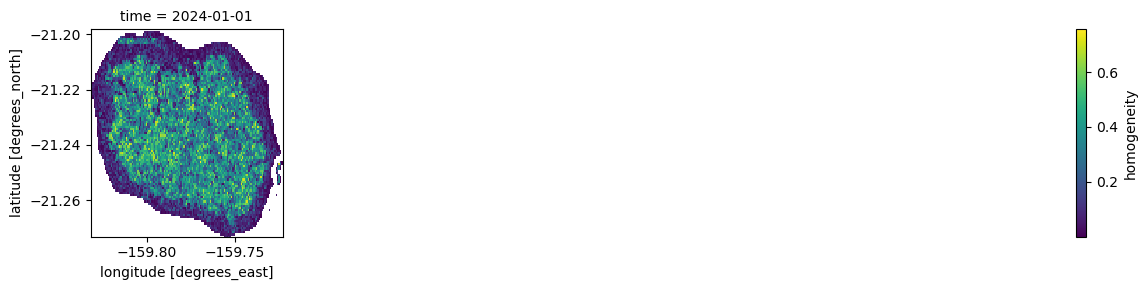

In [132]:
dep.visualise(glcm['homogeneity'])

## Create dataset (data + label) for training

In [129]:
datasets = {
    "spectral": spectral,   
    "fc": fc,               
    "dem": dem_data,
    "fc_jan_apr": fc_jan_apr,
    "fc_may_aug": fc_may_aug,
    "fc_sep_dec": fc_sep_dec, 
    "glcm" : glcm
}

interp_methods = {
    "spectral": "linear",
    "fc": "nearest",
    "dem": "nearest",
    "fc_jan_apr": "nearest",
    "fc_may_aug": "nearest",
    "fc_sep_dec": "nearest",
    "glcm" : "nearest"
}

samples_dict = {}
coords_x = gdf.geometry.x.values
coords_y = gdf.geometry.y.values
n_points = len(gdf)

for name, ds in datasets.items():
    method = interp_methods[name]
    
    for band in ds.data_vars:
        da = ds[band]
        if "time" in da.dims:
            da = da.isel(time=0)
        
        sampled = da.interp(x=coords_x, y=coords_y, method=method)
        sampled_1d = sampled.values.ravel()
        
        # pad if shorter than gdf
        if len(sampled_1d) < n_points:
            pad_len = n_points - len(sampled_1d)
            sampled_1d = np.concatenate([sampled_1d, np.full(pad_len, np.nan)])
        
        samples_dict[band] = sampled_1d[:n_points]

# Create DataFrame
df_samples = pd.DataFrame(samples_dict)
df_samples["lulc"] = gdf["lulc"].values
df_samples["class_id"] = gdf["class_id"].values

# Merge with geometry
gdf_sampled = gdf.copy()
for col in df_samples.columns:
    gdf_sampled[col] = df_samples[col]

# Drop NaN 
gdf_sampled = gdf_sampled.dropna()

# Save as GeoJSON
out_path = "./data/preparation/cook_dataset.geojson"
gdf_sampled.to_file(out_path, driver="GeoJSON")
print(f" Saved GeoJSON with {len(gdf_sampled)} points to '{out_path}'")

# Save as CSV
gdf_sampled.to_csv('./data/preparation/cook_dataset.csv')

 Saved GeoJSON with 688 points to './data/preparation/cook_dataset.geojson'
